In [158]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import torch.optim as optim

In [159]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [160]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

one_image_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # For visualising

In [161]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

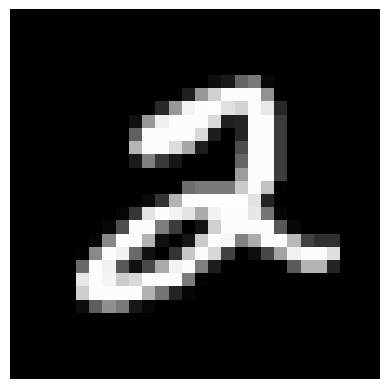

In [162]:
plot_image(train_dataset[5][0])

# Gaussian-Gaussian Autoencoder:

In [163]:
class GaussianAutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256, classification = False):
        super(GaussianAutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================


        # Appendix C.2, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_3 that make up theta
            nn.Tanh()
        )

        if classification:
            self.output_u_prediction_head = nn.Sequential(
            nn.Linear(inter_dim, input_dim), # Here are the weights W_4 that make up theta
            nn.Sigmoid() # Page 6 last sentence explains this part
            )
        else:
            nn.Linear(inter_dim,input_dim) # Here are the weights W_4 that make up theta

        self.output_variance_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_5 that make up theta
        # ---------------------------------------------------------------------------------

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_logvariance = self.latent_variance_prediction_head(h)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, Z):
        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_logvariance = self.output_variance_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        return output_u, output_logvariance # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_variance)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()

        Z = latent_u + latent_logvariance*sampled_error_e # Latent variables Z

        X_hat, logvariance = self.decoder_forward(Z)

        return X_hat, logvariance, latent_u, latent_logvariance

# Gaussian-Bernoulli Autoencoder:

In [164]:
class BernoulliAutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256):
        super(BernoulliAutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
            nn.Linear(inter_dim, inter_dim), # (not in paper) I added additional layer for better performance
            nn.Tanh()
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================


        # Appendix C.1, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_1 that make up theta
            nn.Tanh(),
            nn.Linear(inter_dim, inter_dim), # (not in paper) I added additional layer for better performance
            nn.Tanh(),
            nn.Linear(inter_dim, input_dim), # Here are the weights W_2 that make up theta
            nn.Sigmoid()
        )
        # ---------------------------------------------------------------------------------


    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_logvariance = self.latent_variance_prediction_head(h)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, Z):
        return self.decoder_mlp(Z) # These are the estimates of parameters for p_theta(X|Z) ~ Bernoulli(Z)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()

        Z = latent_u + latent_logvariance*sampled_error_e # Latent variables Z

        X_hat = self.decoder_forward(Z)

        return X_hat, latent_u, latent_logvariance

# Testing whether the VAE works:

In [165]:
BVAE = BernoulliAutoEncodingVariationalBayes(784, 2)

single_image, _ = next(iter(one_image_loader))
single_image = single_image.view(single_image.size(0),-1)

BVAE(single_image)

(tensor([[0.4983, 0.4974, 0.4768, 0.5181, 0.5469, 0.4853, 0.4987, 0.5514, 0.5774,
          0.5421, 0.4845, 0.4862, 0.4945, 0.4917, 0.5044, 0.5087, 0.4634, 0.4817,
          0.4496, 0.4872, 0.4453, 0.4660, 0.4453, 0.5087, 0.5255, 0.5197, 0.4888,
          0.5244, 0.4892, 0.5261, 0.5054, 0.5584, 0.5168, 0.5239, 0.5086, 0.4685,
          0.5327, 0.4743, 0.4890, 0.5185, 0.5229, 0.4804, 0.5512, 0.4652, 0.4937,
          0.5285, 0.5292, 0.5135, 0.4667, 0.5285, 0.4993, 0.4712, 0.4602, 0.5079,
          0.4658, 0.5022, 0.5236, 0.4800, 0.4971, 0.4932, 0.5086, 0.5337, 0.5130,
          0.5356, 0.5721, 0.5054, 0.4426, 0.5341, 0.4917, 0.5008, 0.5098, 0.5320,
          0.5094, 0.5311, 0.5191, 0.4631, 0.5241, 0.5285, 0.4904, 0.4656, 0.5178,
          0.5288, 0.4987, 0.5092, 0.5557, 0.5855, 0.6099, 0.4802, 0.4950, 0.4725,
          0.5058, 0.4398, 0.4911, 0.4952, 0.5080, 0.4672, 0.5329, 0.4599, 0.5202,
          0.4685, 0.5317, 0.5286, 0.5564, 0.4700, 0.5053, 0.4998, 0.5211, 0.4981,
          0.4943

# Gaussian Reconstruction Loss:

In [166]:
def gaussian_log_likelihood(X, X_hat, logvar):
    reconstruction_loss = torch.sum(-0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar + (X - X_hat) ** 2 / torch.exp(logvar)))
    return reconstruction_loss / X.size(0)  # Normalize by batch size

# Bernoulli Reconstruction Loss:

In [167]:
def bernoulli_log_likelihood(X, X_hat):
    X_hat = X_hat.clamp(min=0, max=1)
    X = X.clamp(min=0, max=1)
    bce_loss = torch.nn.functional.binary_cross_entropy(X_hat, X, reduction='sum')
    return bce_loss / X.size(0)

# Kullback Leiber Divergence:

In [168]:
def kullback_leiber_divergence(latent_u, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_u.pow(2) - latent_logvar.exp())
    return kl_div

# Bernoulli Training

In [169]:
# The paper mentions initializing parameters with N(0, 0.01), but I've also provided a xavier initialization
def init_weights_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [170]:
BVAE = BernoulliAutoEncodingVariationalBayes(784, 2, 248) # I find lower width but 1 more depth significantly improves quality
BVAE.apply(init_weights_normal)
num_epochs = 20


optimizer = optim.Adam(BVAE.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)# Adjust learning rate as needed


for epoch in range(num_epochs):
    BVAE.train()
    train_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()


        X_hat, latent_u, latent_logvar  = BVAE(data)

        # Loss = D_kl + L_reconstruction
        kl_div_loss = kullback_leiber_divergence(latent_u, latent_logvar)
        recon_loss = bernoulli_log_likelihood(data, X_hat)
        loss = kl_div_loss + recon_loss

        if torch.isnan(loss):
            print("Stopping training due to NaN loss")
            break

        # Backward pass and optimize
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

    # scheduler.step()
    # Compute average loss for this epoch
    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/20], Loss: 2.1770
Epoch [2/20], Loss: 2.1616
Epoch [3/20], Loss: 2.0557
Epoch [4/20], Loss: 2.0344
Epoch [5/20], Loss: 2.0243
Epoch [6/20], Loss: 2.0465
Epoch [7/20], Loss: 2.0891
Epoch [8/20], Loss: 2.0224
Epoch [9/20], Loss: 1.9978
Epoch [10/20], Loss: 1.9890
Epoch [11/20], Loss: 2.1154
Epoch [12/20], Loss: 1.9900
Epoch [13/20], Loss: 1.9676
Epoch [14/20], Loss: 1.9129
Epoch [15/20], Loss: 1.9255
Epoch [16/20], Loss: 1.8779
Epoch [17/20], Loss: 1.8912
Epoch [18/20], Loss: 1.9041
Epoch [19/20], Loss: 1.8828
Epoch [20/20], Loss: 1.8766


# Plotting reconstructed image

In [171]:
def plot_images(original, reconstructed, height, width):

    if original.shape[0] == 1:
        original = original.squeeze(0)
    if len(original.shape) > 2:
        original = original.view(height, width)

    reconstructed = reconstructed.view(height, width)

    original_np = original.numpy()
    reconstructed_np = reconstructed.detach().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_np, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()

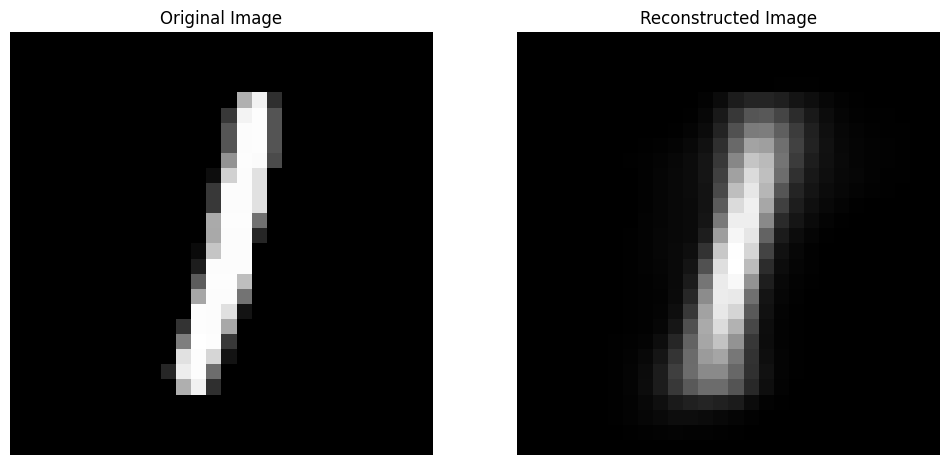

In [175]:
image = next(iter(one_image_loader))[0].squeeze(0)
height, width = image.shape[1], image.shape[2]
predict_format = image.view(image.size(0), -1)

image_hat, _, __ = BVAE(predict_format)

plot_images(image, image_hat, height, width)

In [176]:
def plot_latent_manifolds(model, height, width, num_points=20, scale = 1):


    z1 = np.linspace(-scale, scale, num_points)
    z2 = np.linspace(-scale, scale, num_points)
    z1, z2 = np.meshgrid(z1, z2)
    z_grid = np.vstack([z1.flatten(), z2.flatten()]).transpose()


    with torch.no_grad():
        model.eval()
        images = []
        for i in range(z_grid.shape[0]):
            z_sample = torch.tensor(z_grid[i]).float().unsqueeze(0)
            img = model.decoder_forward(z_sample).view(height, width).numpy()
            images.append(img)


    fig, ax = plt.subplots(num_points, num_points, figsize=(15, 15))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i], cmap='gray')
        axi.axis('off')

    plt.show()

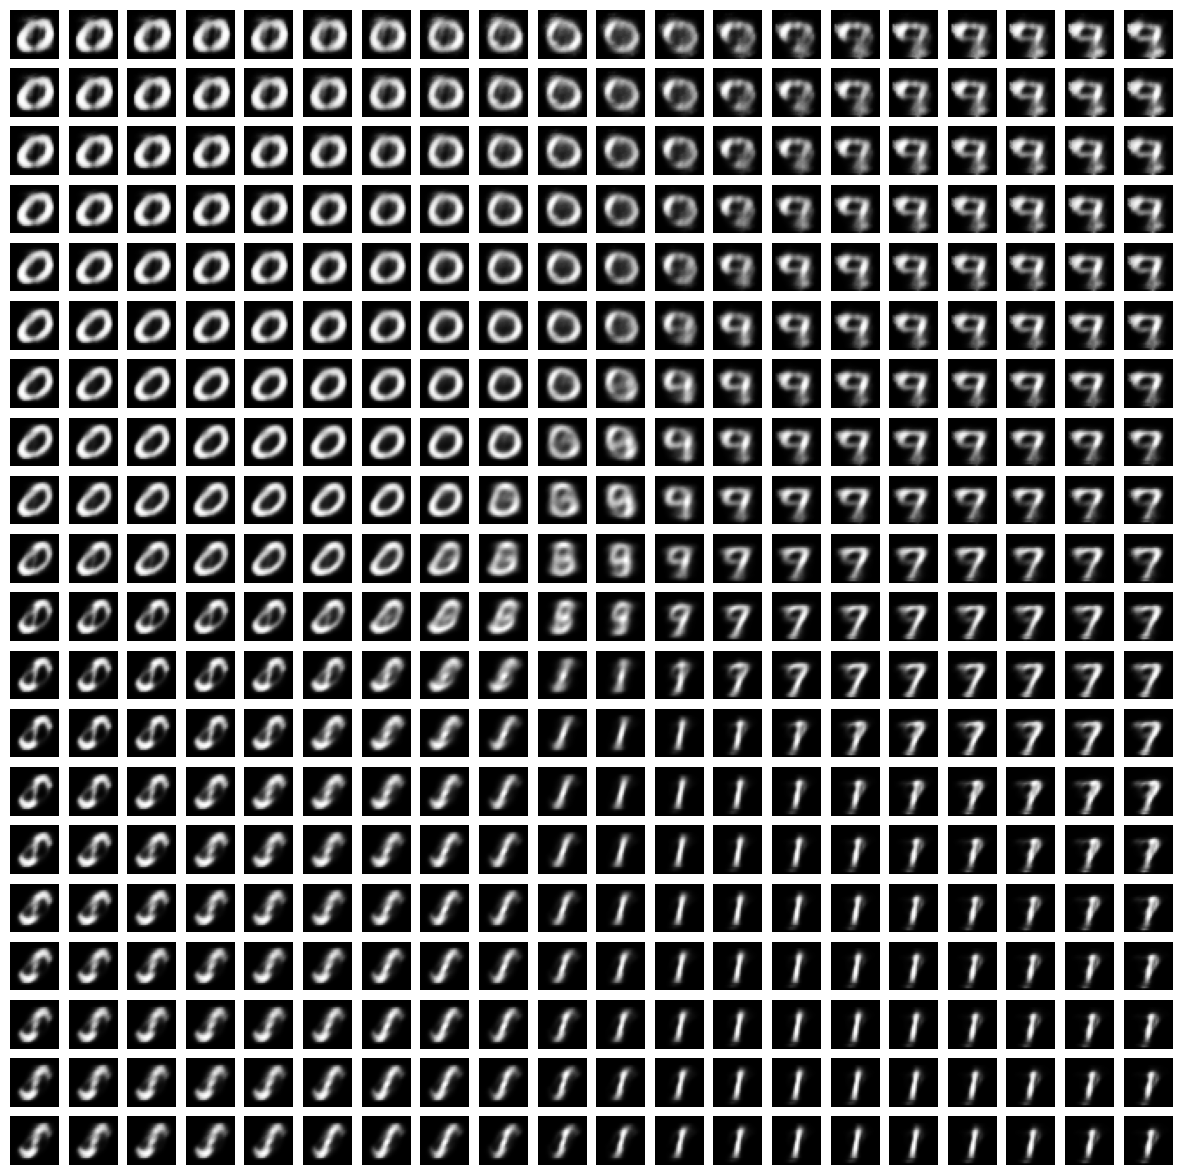

In [177]:
plot_latent_manifolds(BVAE, 28, 28, scale=2)

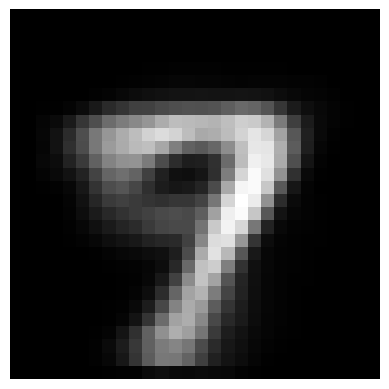

In [178]:
x_decoded = BVAE.decoder_forward(torch.tensor([1,0]).float())
digit = x_decoded.detach().cpu().reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

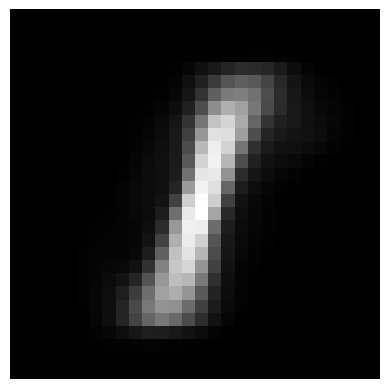

In [179]:
x_decoded = BVAE.decoder_forward(torch.tensor([0,1]).float())
digit = x_decoded.detach().cpu().reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()